In [1]:
import os,sys
sys.path.append('/w/jam-sciwork18/pitonyak/jam3d_dev')
os.environ["JAM3D"] = "/w/jam-sciwork18/pitonyak/jam3d_dev"
from tools.tools     import checkdir,save,load,lprint
import tools.config
from tools.config    import load_config, conf
import numpy as np
from tmd import TMD
import matplotlib as plt
import pylab as py
import pandas as pd
from scipy.integrate import quad, fixed_quad

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m7oku2qr because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load the TMD class

In [16]:
tag='JAM3D_2022' 
tmd=TMD(tag)

parman: pdf
order: [1, 'pdf', 'widths1_uv']
order: [1, 'pdf', 'widths1_sea']
parman: pdfpi-
parman: ffpi
order: [1, 'ffpi', 'widths1_fav']
order: [1, 'ffpi', 'widths1_ufav']
parman: ffk
order: [1, 'ffk', 'widths1_fav']
order: [1, 'ffk', 'widths1_ufav']
parman: ffh
parman: transversity
order: [1, 'transversity', 'widths1_uv']
order: [1, 'transversity', 'u N0 1']
order: [1, 'transversity', 'u N1 1']
order: [1, 'transversity', 'u a0 1']
order: [1, 'transversity', 'u b0 1']
order: [1, 'transversity', 'u b1 1']
order: [1, 'transversity', 'd N0 1']
order: [1, 'transversity', 'd N1 1']
order: [1, 'transversity', 'd a0 1']
parman: collinspi
order: [1, 'collinspi', 'widths1_fav']
order: [1, 'collinspi', 'widths1_ufav']
order: [1, 'collinspi', 'u N0 1']
order: [1, 'collinspi', 'u N1 1']
order: [1, 'collinspi', 'u a0 1']
order: [1, 'collinspi', 'u a1 1']
order: [1, 'collinspi', 'u b0 1']
order: [1, 'collinspi', 'u b1 1']
order: [1, 'collinspi', 'u b0 2']
order: [1, 'collinspi', 'u b1 2']
order: [

Tag is for a given analysis. See the table in the readme file.

In [17]:
M = 0.93891897
Mpi = 0.135

## Simple test

In [18]:
x=0.1
Q2=10.0
kT=0.1
print(tmd.eval(x,Q2,kT,'p','transversity',0,icol=False))
print(tmd.eval(x,Q2,kT,'p','transversity',0,icol=True))

[ 0.          0.39800348  0.         -0.08438093  0.          0.
  0.          0.          0.          0.          0.        ]
[ 0.          1.92081833  0.         -0.40723373  0.          0.
  0.          0.          0.          0.          0.        ]


- icol=False will give the full TMD while icol=True will return only the collinear part: see Eqs. (3)-(7) of arXiv:2002.08384 


- The 5th argument in tmd.eval is the hadron (p: proton, pi: pion)


- The 6th argument in tmd.eval is the replica index (0 is chosen in this case). You can get the number of replicas via tmd.nrep:


In [19]:
x=0.1
z=0.1
Q2=10.0
pT=0.1
print(tmd.eval_stfunc('FUU',x,z,Q2,pT,'p','pi+',0,icol=False))
print(tmd.eval_TMDasym('Siv',x,z,Q2,pT,'p','pi+',0,icol=False))

5.359273560534195
0.0029417608791527093


- tmd.eval_stfunc gives the structure function: 'FUU' for unpolarized; 'FUTSiv' for Sivers; 'FUTCol' for Collins


- tmd.eval_asymmetry gives the asymmetry: Sivers ('Siv') = FUTSiv/FUU; Collins ('Col') = FUTCol/FUU (NO depolarization factor)


- The 8th argument in tmd.eval_stfunc and tmd.eval_asymmetry is the replica index (0 is chosen in this case). You can get the number of replicas via tmd.nrep:

In [20]:
tmd.nrep

465

## Sivers asymmetry example

In [21]:
data=pd.DataFrame(pd.read_excel('../jam3d_dev/database/sidis/expdata/2001.xlsx'))
data.reset_index()
data=data[(data.Q2>1.63) & (data.z>0.2) & (data.z<0.6) & (data.pT>0.2) & (data.pT<0.9)]
print(data)

    i  Ebeam      x      y      z     Q2     pT        obs   value  stat_u  \
1   8   27.6  0.056  0.569  0.356  1.631  0.409  AUTsivers  0.0264  0.0071   
2   9   27.6  0.076  0.513  0.367  2.017  0.372  AUTsivers  0.0542  0.0078   
3  10   27.6  0.098  0.484  0.376  2.467  0.356  AUTsivers  0.0516  0.0070   
4  11   27.6  0.133  0.464  0.379  3.203  0.344  AUTsivers  0.0361  0.0066   
5  12   27.6  0.186  0.449  0.379  4.321  0.339  AUTsivers  0.0531  0.0086   
6  13   27.6  0.275  0.434  0.375  6.179  0.344  AUTsivers  0.0546  0.0118   

   systrel  systabs_u  target hadron     col Dependence  
1        0     0.0017  proton    pi+  hermes          x  
2        0     0.0024  proton    pi+  hermes          x  
3        0     0.0033  proton    pi+  hermes          x  
4        0     0.0046  proton    pi+  hermes          x  
5        0     0.0064  proton    pi+  hermes          x  
6        0     0.0093  proton    pi+  hermes          x  


- load an experimental data set (with cuts on Q^2, z, and pT); in this case, we are using HERMES proton Sivers data for pi+ production

In [22]:
tar=np.array(data['target'])[0]
if tar=='proton': tar='p'
elif tar=='neutron': tar='n'
elif tar=='deuteron': tar='d'

had=np.array(data['hadron'])[0]

obs=np.array(data['obs'])[0]
if obs=='AUTsivers': obs='Siv'
elif obs=='AUTcollins': obs='Col'

xarr=np.array(data['x'])
zarr=np.array(data['z'])
Q2arr=np.array(data['Q2'])
pTarr=np.array(data['pT'])
asym=map(lambda x,z,Q2,pT: tmd.eval_TMDasym(obs,x,z,Q2,pT,tar,had,0,icol=False),xarr,zarr,Q2arr,pTarr)
asym=np.array(list(asym))

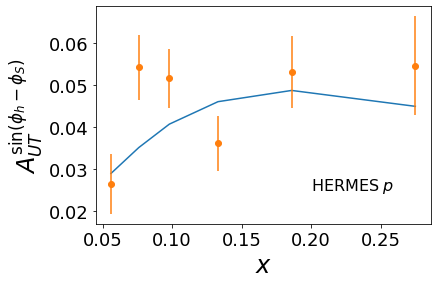

In [23]:
ax=py.subplot(111)
ax.plot(xarr,asym,linestyle='-')
ax.errorbar(xarr,data['value'],data['stat_u'],marker='o',linestyle='')
ax.set_xlabel('$x$',size=24)
ax.set_ylabel('$A_{UT}^{\sin(\phi_h-\phi_S)}$',size=24)
ax.text(0.2,0.025,r'${\rm HERMES}\;p$',fontsize=16)
ax.tick_params(labelsize=18)

py.show()

## AN in pp asymmetry example

In [24]:
data=pd.DataFrame(pd.read_excel('../jam3d_dev/database/AN_pp/expdata/2003.xlsx'))
data.reset_index()
data=data[(data.xF>0)]
print(data)

      xF    value  stat_err_u  sys_err_u    pT   rs target hadron   col obs
0  0.237  0.00571     0.00579     0.0063  1.19  200      p    pi0  STAR  AN
1  0.283  0.00192     0.00122     0.0004  1.34  200      p    pi0  STAR  AN
2  0.322  0.00909     0.00093     0.0004  1.53  200      p    pi0  STAR  AN
3  0.371  0.02343     0.00144     0.0004  1.79  200      p    pi0  STAR  AN
4  0.427  0.03859     0.00228     0.0008  2.04  200      p    pi0  STAR  AN
5  0.501  0.06916     0.00478     0.0004  2.36  200      p    pi0  STAR  AN
6  0.598  0.10345     0.01369     0.0051  2.78  200      p    pi0  STAR  AN


In [25]:
tar=np.array(data['target'])[0]
if tar=='proton': tar='p'

had=np.array(data['hadron'])[0]

rs=np.array(data['rs'])[0]

obs=np.array(data['obs'])[0]
if obs=='AN': obs='ANpp'

xFarr=np.array(data['xF'])
pTarr=np.array(data['pT'])
asym=map(lambda xF,pT: tmd.eval_ANasym(obs,xF,pT,rs,tar,had,irep=0),xFarr,pTarr)
asym=np.array(list(asym))

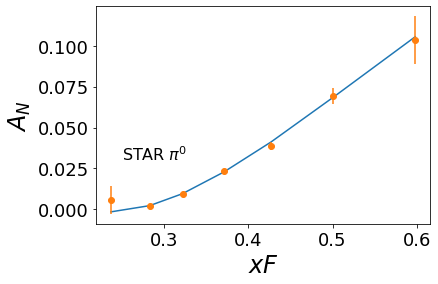

In [26]:
ax=py.subplot(111)
ax.plot(xFarr,asym,linestyle='-')
err=np.sqrt(data['stat_err_u']**2 + data['sys_err_u']**2)
ax.errorbar(xFarr,data['value'],err,marker='o',linestyle='')
ax.set_xlabel('$xF$',size=24)
ax.set_ylabel('$A_N$',size=24)
ax.text(0.25,0.03,r'${\rm STAR}\; \pi^0$',fontsize=16)
ax.tick_params(labelsize=18)

py.show()

## Transversity (collinear)

Generate the data

In [27]:
X=np.linspace(0.01,0.99,100)
Q2=4.0
kT=0.0
nrep=50  #--let's use a subset of the replicas
tran=np.array([[tmd.eval(x,Q2,kT,'p','transversity',irep,icol=True) for x in X] for irep in range(nrep)])
print(tran.shape)

(50, 100, 11)


- This is 50 replicas, 100 x-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot u and d

In [28]:
u_rep=tran[:,:,1]
d_rep=tran[:,:,3]

u  = np.mean(u_rep,axis=0)
du = np.std(u_rep,axis=0)
d  = np.mean(d_rep,axis=0)
dd = np.std(d_rep,axis=0)


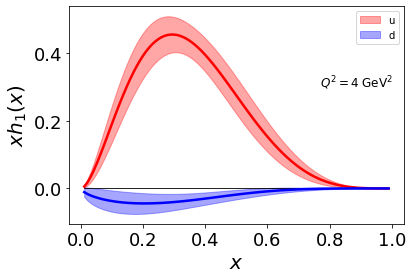

In [29]:
ax=py.subplot(111)
ax.fill_between(X,X*(u-du),X*(u+du),color="r",alpha=0.35,label='u')
ax.fill_between(X,X*(d-dd),X*(d+dd),color="b",alpha=0.35,label='d')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(X,X*u,color="r",linewidth=2.5)
ax.plot(X,X*d,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$xh_1(x)$',size=20)
ax.set_xlabel(r'$x$',size=20)
ax.text(0.77,0.3,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12)
ax.tick_params(labelsize=18)


py.show()

## Transversity (TMD)

Generate the data

In [30]:
KT=np.linspace(0.01,0.99,100)
Q2=4.0
x=0.1
nrep=50  #--let's use a subset of the replicas
trankT=np.array([[tmd.eval(x,Q2,kT,'p','transversity',irep,icol=False) for kT in KT] for irep in range(nrep)])
print(trankT.shape)

(50, 100, 11)


- This is 50 replicas, 100 kT-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot u and d

In [31]:
u_repkT=trankT[:,:,1]
d_repkT=trankT[:,:,3]

ukT  = np.mean(u_repkT,axis=0)
dukT = np.std(u_repkT,axis=0)
dkT  = np.mean(d_repkT,axis=0)
ddkT = np.std(d_repkT,axis=0)


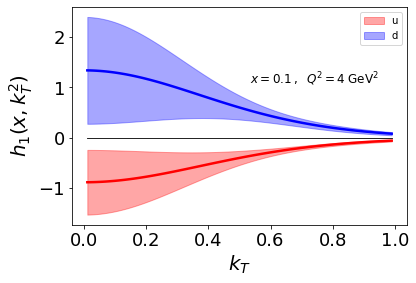

In [63]:
ax=py.subplot(111)
ax.fill_between(KT,(ukT-dukT),(ukT+dukT),color="r",alpha=0.35,label='u')
ax.fill_between(KT,(dkT-ddkT),(dkT+ddkT),color="b",alpha=0.35,label='d')


ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(KT,ukT,color="r",linewidth=2.5)
ax.plot(KT,dkT,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$h_1(x,k_T^2)$',size=20)
ax.set_xlabel(r'$k_T$',size=20)
ax.text(0.53,0.65,r'$x=0.1\,,$',fontsize=12,transform=ax.transAxes)
ax.text(0.7,0.65,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12,transform=ax.transAxes)
ax.tick_params(labelsize=18)


py.show()

## Sivers first moment (collinear)

Generate the data

In [34]:
X=np.linspace(0.01,0.99,100)
Q2=4.0
kT=0.0
nrep=50  #--let's use a subset of the replicas
siv=np.array([[tmd.eval(x,Q2,kT,'p','sivers',irep,icol=True) for x in X] for irep in range(nrep)])
print(siv.shape)

(50, 100, 11)


- This is 50 replicas, 100 x-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot u and d

In [35]:
u_rep=siv[:,:,1]
d_rep=siv[:,:,3]

u  = np.mean(u_rep,axis=0)
du = np.std(u_rep,axis=0)
d  = np.mean(d_rep,axis=0)
dd = np.std(d_rep,axis=0)


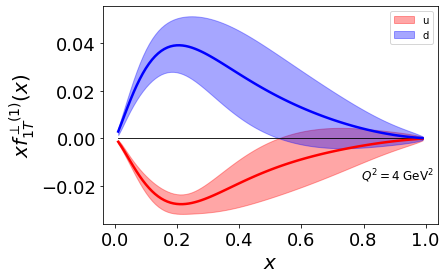

In [36]:
ax=py.subplot(111)
ax.fill_between(X,X*(u-du),X*(u+du),color="r",alpha=0.35,label='u')
ax.fill_between(X,X*(d-dd),X*(d+dd),color="b",alpha=0.35,label='d')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(X,X*u,color="r",linewidth=2.5)
ax.plot(X,X*d,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$xf_{1T}^{\perp(1)}(x)$',size=20)
ax.set_xlabel(r'$x$',size=20)
ax.text(0.77,0.2,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12,transform=ax.transAxes)
ax.tick_params(labelsize=18)


py.show()

## Sivers (TMD)

Generate the data

In [37]:
KT=np.linspace(0.01,0.99,100)
Q2=4.0
x=0.1
nrep=50  #--let's use a subset of the replicas
sivkT=np.array([[tmd.eval(x,Q2,kT,'p','sivers',irep,icol=False) for kT in KT] for irep in range(nrep)])
print(sivkT.shape)

(50, 100, 11)


- This is 50 replicas, 100 kT-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot u and d

In [38]:
u_repkT=sivkT[:,:,1]
d_repkT=sivkT[:,:,3]

ukT  = np.mean(u_repkT,axis=0)
dukT = np.std(u_repkT,axis=0)
dkT  = np.mean(d_repkT,axis=0)
ddkT = np.std(d_repkT,axis=0)


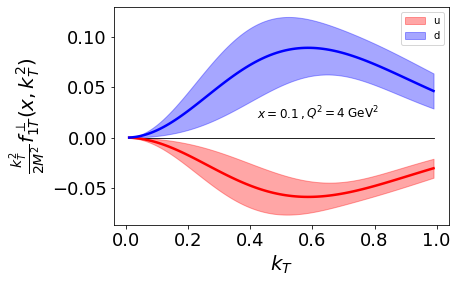

In [39]:
ax=py.subplot(111)
ax.fill_between(KT,KT**2/(2.*M**2)*(ukT-dukT),KT**2/(2.*M**2)*(ukT+dukT),color="r",alpha=0.35,label='u')
ax.fill_between(KT,KT**2/(2.*M**2)*(dkT-ddkT),KT**2/(2.*M**2)*(dkT+ddkT),color="b",alpha=0.35,label='d')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(KT,KT**2/(2.*M**2)*ukT,color="r",linewidth=2.5)
ax.plot(KT,KT**2/(2.*M**2)*dkT,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$\frac{k_T^2}{2 M^2}f_{1T}^\perp(x,k_T^2)$',size=20)
ax.set_xlabel(r'$k_T$',size=20)
ax.text(0.42,0.02,r'$x=0.1\,,$',fontsize=12)
ax.text(0.58,0.02,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12)
ax.tick_params(labelsize=18)


py.show()

## Collins first moment (collinear)

Generate the data

In [40]:
X=np.linspace(0.01,0.99,100)
Q2=4.0
kT=0.0
nrep=50  #--let's use a subset of the replicas
col=np.array([[tmd.eval(x,Q2,kT,'pi','collinspi',irep,icol=True) for x in X] for irep in range(nrep)])
print(col.shape)

(50, 100, 11)


- This is 50 replicas, 100 z-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot favored and unfavored

In [41]:
fav_rep=col[:,:,1]
unf_rep=col[:,:,3]

fav  = np.mean(fav_rep,axis=0)
dfav = np.std(fav_rep,axis=0)
unf  = np.mean(unf_rep,axis=0)
dunf = np.std(unf_rep,axis=0)


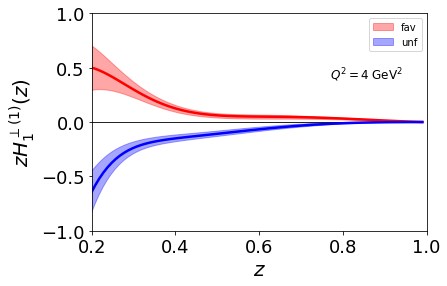

In [42]:
ax=py.subplot(111)
ax.fill_between(X,X*(fav-dfav),X*(fav+dfav),color="r",alpha=0.35,label='fav')
ax.fill_between(X,X*(unf-dunf),X*(unf+dunf),color="b",alpha=0.35,label='unf')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(X,X*fav,color="r",linewidth=2.5)
ax.plot(X,X*unf,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$zH_{1}^{\perp(1)}(z)$',size=20)
ax.set_xlabel(r'$z$',size=20)
ax.text(0.77,0.4,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12)
ax.tick_params(labelsize=18)

ax.set_xlim(0.2,1)
ax.set_ylim(-1,1)

py.show()

## Collins (TMD)

Generate the data

In [43]:
KT=np.linspace(0.01,0.99,100)
Q2=4.0
z=0.3
nrep=50  #--let's use a subset of the replicas
colkT=np.array([[tmd.eval(z,Q2,kT,'pi','collinspi',irep,icol=False) for kT in KT] for irep in range(nrep)])
print(colkT.shape)

(50, 100, 11)


- This is 50 replicas, 100 kT-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot u and d

In [44]:
fav_repkT=colkT[:,:,1]
unf_repkT=colkT[:,:,3]

favkT  = np.mean(fav_repkT,axis=0)
dfavkT = np.std(fav_repkT,axis=0)
unfkT  = np.mean(unf_repkT,axis=0)
dunfkT = np.std(unf_repkT,axis=0)


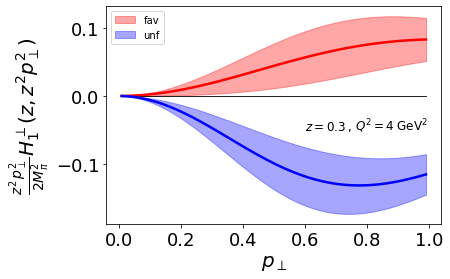

In [45]:
ax=py.subplot(111)
ax.fill_between(KT,z**2*KT**2/(2.*Mpi**2)*(favkT-dfavkT),z**2*KT**2/(2.*Mpi**2)*(favkT+dfavkT),color="r",alpha=0.35,label='fav')
ax.fill_between(KT,z**2*KT**2/(2.*Mpi**2)*(unfkT-dunfkT),z**2*KT**2/(2.*Mpi**2)*(unfkT+dunfkT),color="b",alpha=0.35,label='unf')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(KT,z**2*KT**2/(2.*Mpi**2)*favkT,color="r",linewidth=2.5)
ax.plot(KT,z**2*KT**2/(2.*Mpi**2)*unfkT,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$\frac{z^2\,p_\perp^2}{2 M_\pi^2}H_{1}^\perp(z,z^2 p_\perp^2)$',size=20)
ax.set_xlabel(r'$p_\perp$',size=20)
ax.text(0.6,-0.05,r'$z=0.3\,,$',fontsize=12)
ax.text(0.76,-0.05,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12)
ax.tick_params(labelsize=18)


py.show()

## H-tilde (collinear)

Generate the data

In [46]:
X=np.linspace(0.01,0.99,100)
Q2=4.0
kT=0.0
nrep=50  #--let's use a subset of the replicas
col=np.array([[tmd.eval(x,Q2,kT,'pi','Htildepi',irep,icol=True) for x in X] for irep in range(nrep)])
print(col.shape)

(50, 100, 11)


- This is 50 replicas, 100 z-values and 11 partons


- 11 partons: 0=g,1=u,2=ub,3=d,4=db,5=s,6=sb,7=c,8=cb,9=b,10=bb

Plot favored and unfavored

In [47]:
fav_rep=col[:,:,1]
unf_rep=col[:,:,3]

fav  = np.mean(fav_rep,axis=0)
dfav = np.std(fav_rep,axis=0)
unf  = np.mean(unf_rep,axis=0)
dunf = np.std(unf_rep,axis=0)


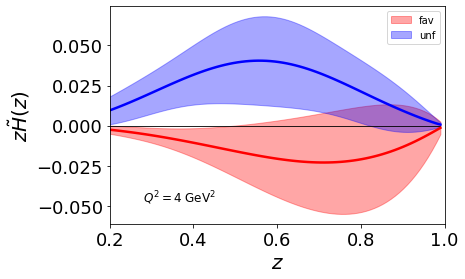

In [52]:
ax=py.subplot(111)
ax.fill_between(X,X*(fav-dfav),X*(fav+dfav),color="r",alpha=0.35,label='fav')
ax.fill_between(X,X*(unf-dunf),X*(unf+dunf),color="b",alpha=0.35,label='unf')

ax.plot(X,X*0,color="k",linewidth=0.85)

ax.plot(X,X*fav,color="r",linewidth=2.5)
ax.plot(X,X*unf,color="b",linewidth=2.5)

ax.legend()

ax.set_ylabel(r'$z\tilde{H}(z)$',size=20)
ax.set_xlabel(r'$z$',size=20)
ax.text(0.1,0.1,r'$Q^2=4\; {\rm GeV}^2$',fontsize=12,transform=ax.transAxes)
ax.tick_params(labelsize=18)

ax.set_xlim(0.2,1)

py.show()